In [1]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import os                                               #os interface library 
import requests                                         #HTTP requests library
import pandas as pd                                     #panda library
from dotenv import load_dotenv                          #dotenv library to read keys and secrect key for api
import alpaca_trade_api as trade_api                    #Alpaca library
from MCForecastTools import MCSimulation                #Monta Carlos simulation apis
from datetime import date                               #Data-Time library
import numpy as np                                      #Numpy library
from ipywidgets import *                                #Interactive Widgets library
from matplotlib import pyplot as plt                    #Map plot library
import matplotlib.gridspec as gridspec                  #Gridspec library
import panel as pn                                      #Librariy for panels
#pn.extension()                                          #Load panel extension
pn.extension('plotly')


#set the backend of matplotlib to the 'inline' backend 
%matplotlib inline 


Bad key savefig.frameon in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\ProgramData\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probab

In [2]:
# Load .env enviroment variables
load_dotenv()

True

In [3]:
#Set up the alpaca trading API to retrieve data
def setting_api():
    alpaca_api_key=os.getenv("ALPACA_API_KEY")                                    #Set the Alpaca Key
    alpaca_secret_key=os.getenv("ALPACA_SECRET_KEY")                              #Set the Alpaca secret key
    alpaca = trade_api.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')  #Set the REST api with URL and keys
    return alpaca                                                                 #Return the Alpaca API object


#Function for retrieving data relative to tickers/portfolio
def portfolio_data(tickers):
    today = date.today() + pd.DateOffset(years=-5)                                #Set Start date 5 years back from now                    
    today = pd.Timestamp(today, tz="America/New_York").isoformat()                #convert to ISO datetime format
    timeframe ='1Day'                                                             #Set to retrive day trade data
    portfolio =alpaca.get_bars(tickers,timeframe,start=today,adjustment='raw').df #Get the trading info based on the ticker
    portfolio.index = portfolio.index.date                                        #Set index key to date column 
    return portfolio                                                              #Return the extracted value


#function for retrieving data related to benchmark:
def bench_mark(symbol):
    bench_mark = portfolio_data(symbol)                                           #Get benchmark data from Alpaca API for giventicker
    symbol = bench_mark[['close']].rename(columns = {'close': symbol})            #Rename column from 'close' to ticker name
    return symbol                                                                 #Return the extracted value


#function to seperate the required data :
def format_data(symbol):
    ticker =portfolio[portfolio["symbol"]==symbol].drop("symbol", axis=1)         #Extract ticker based on given symbol value
    closing_price = ticker[['close']]                                             #Extract close price only for that ticker
    closing_price = closing_price.rename(columns={'close' : symbol})              #Rename the column to "close"
    return closing_price                                                          #Return the extracted value


#function for calculating cuumulative returns:
def cumulative_returns(data):
    data_returns = data.pct_change()                                             #Calculate % change for given df - data
    data_cumulative = (1 + data_returns).cumprod()                               #compute the cumulative product on %change
    return data_cumulative                                                       #Return the extracted value

# function for equally weghting stocks:
def equal_weights(data):
    weights = []                                                                 #Set list variable -> weights
    for i in range(0, len(data.columns)):                                        #Cal weights for each element in -> data
        w = 1 / len(data.columns)
        weights.append(w)                                                        #Append calculated value to weights list
    return weights                                                               #Return the composed list


#Run the MC Simulation
def MC_simulation(Years):
    global simulation_ew                                                        #Set global variable
    text = ""
    if Years > 0:
        simulation_ew = MCSimulation(                                           #run the MC simulation
                MC_data,
                weights=equal_weights(MC_data),
                num_simulation=1000,
                num_trading_days=252*Years)
        simulation_ew.calc_cumulative_return()                                  #Calculate the cumulative return
        summary_stats = simulation_ew.summarize_cumulative_return()             #summary statistics from the MC simulation results
        volatility = round(summary_stats[2] * np.sqrt(252) )                    #Calculate the volatility       
        text = f"<b>Volatility based on this configuration is {text}</b>"       #Form the volatility information
        display(HTML(text))                                                     #Display the volatility
        display(simulation_ew.simulated_return)                                 #Display each cumulative return
        display(simulation_ew.plot_simulation())                                #Plot the simulation


        
#calculating confidenace level based on MC simulation
def confidence_level(Investment):
    """
    MC Simulation must be ran before executing this function
    """
    #global summary_stats
    Investment = Investment.replace('$','')                                     #Remove $
    Investment = Investment.replace(',','')                                     #Remove ','
    Investment = int(Investment)                                                #Convert the value to int
    summary_stats = simulation_ew.summarize_cumulative_return()                 # summary statistics from the MC simulation results
    initial_investment = Investment                                             # Set initial investment

    # Using lower & upper CI to calculate the `95%` confidence level for chosen investment
    ci_lower = round(summary_stats[8] * initial_investment, 2)
    ci_upper = round(summary_stats[9] * initial_investment, 2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${initial_investment:,.02f} in the portfolio"
          f" over a year will end within in the range of"
          f" ${ci_lower:,.02f} and ${ci_upper:,.02f}")

    
#Rename column to close since Mc requires column name "close"    
def condition_data():
    #global conditioned_data, apd, aph, race, tel, iff, glw, portfolio
    global MC_data, portfolio_joint
    #Extract and format each ticker from df-> Portfolio
    apd =format_data('APD')
    aph =format_data('APH')
    race=format_data('RACE')
    tel=format_data('TEL')
    iff=format_data('IFF')
    glw=format_data('GLW')

    apd1 = apd.rename(columns={'APD' : 'close'})
    aph1 = aph.rename(columns={'APH' : 'close'})
    race1 = race.rename(columns={'RACE' : 'close'})
    tel1 = tel.rename(columns={'TEL' : 'close'})
    iff1 = iff.rename(columns={'IFF' : 'close'})
    glw1 = glw.rename(columns={'GLW' : 'close'})
    MC_data = pd.concat([apd1, aph1, race1, tel1, iff1, glw1],
                         axis = 1, keys = ['APD','APH','RACE','TEL','IFF','GLW']
                        )
    #Concatinate all the tickers into one dataframe
    portfolio_joint = pd.concat([apd, aph, race, tel, iff, glw],axis =1)


In [4]:
alpaca = setting_api()                                    #Set the Alpaca API
tickers = ['APD', 'APH', 'RACE', 'TEL', 'IFF', 'GLW']     #Set tickers
portfolio = portfolio_data(tickers)                       #Rtv ticker values using Alpca API
condition_data()                                          #Condition data and dataframe to be used here
portfolio.head()                                          #Show the retrieved value

,open,high,low,close,volume,trade_count,vwap,symbol
2017-04-18,135.04,136.0200,134.72,135.27,701020,10116,135.259170,APD
2017-04-19,135.73,136.0399,134.78,134.96,577819,7170,135.166924,APD
2017-04-20,135.62,137.3400,135.20,136.90,985329,10779,136.676759,APD
2017-04-21,136.87,137.6600,136.82,137.30,1121329,9645,137.275887,APD
2017-04-24,138.79,139.9000,137.91,139.76,1006799,11797,139.453526,APD


In [5]:
spy = bench_mark('SPY')     #Get the benchmark ticker - S&P 500
spy.head()                  #View the retrieved dataframe

,SPY
2017-04-18,233.87
2017-04-19,233.44
2017-04-20,235.34
2017-04-21,234.59
2017-04-24,237.17


In [6]:
#Calculate cumulative portfolio
portfolio_cumulative = cumulative_returns(portfolio_joint)             #Calculate cumulative returns for stock portfolio
portfolio_cumulative.dropna(inplace=True) 

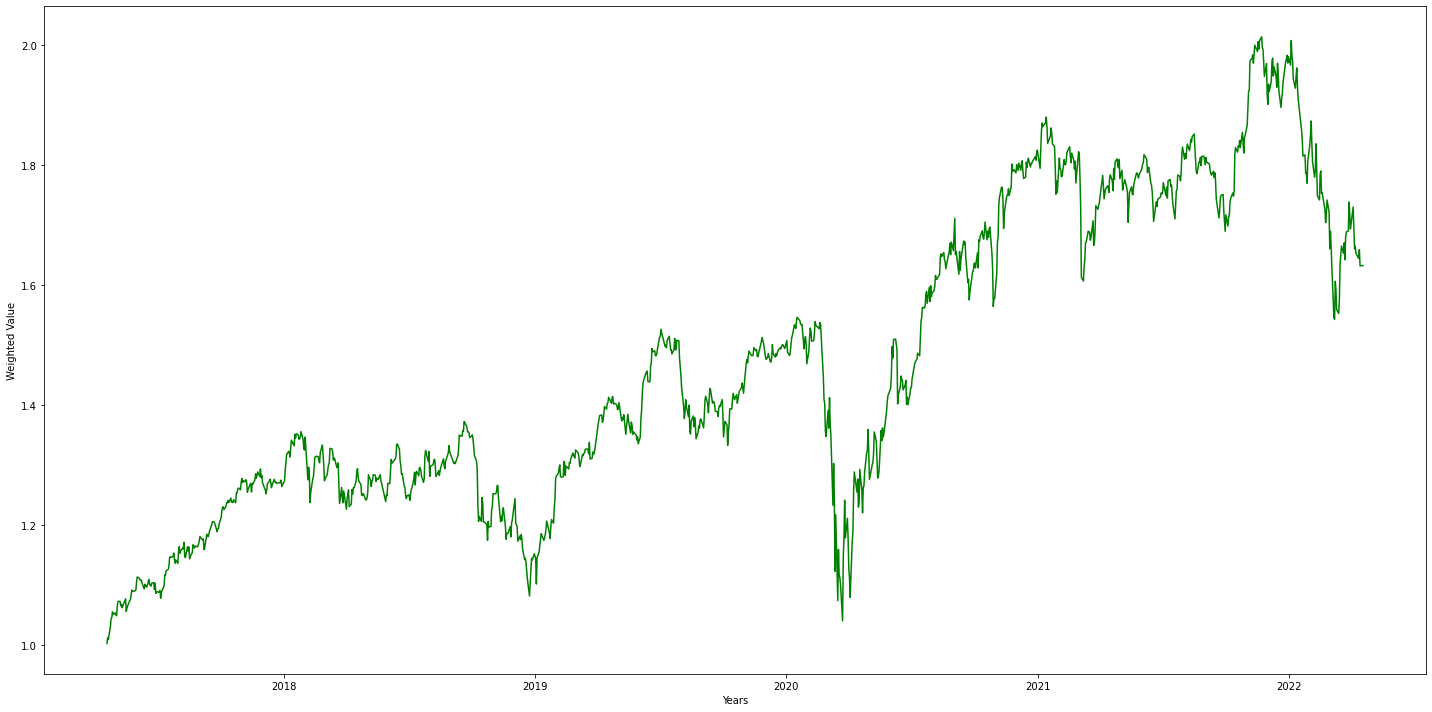

In [7]:
weights = equal_weights(portfolio_joint)                          #Calculate the equal weighted value for each ticker
portfolio_price_action = portfolio_cumulative.dot(weights)        #Get the cumulative product by weights for each tickers

#Plot line graph
portfolio_price_action.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years', color='g')  
plt.savefig('Images/portfolio_price_action', bbox_inches='tight')    #Save the graph

In [27]:
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})                                        #Give a column name

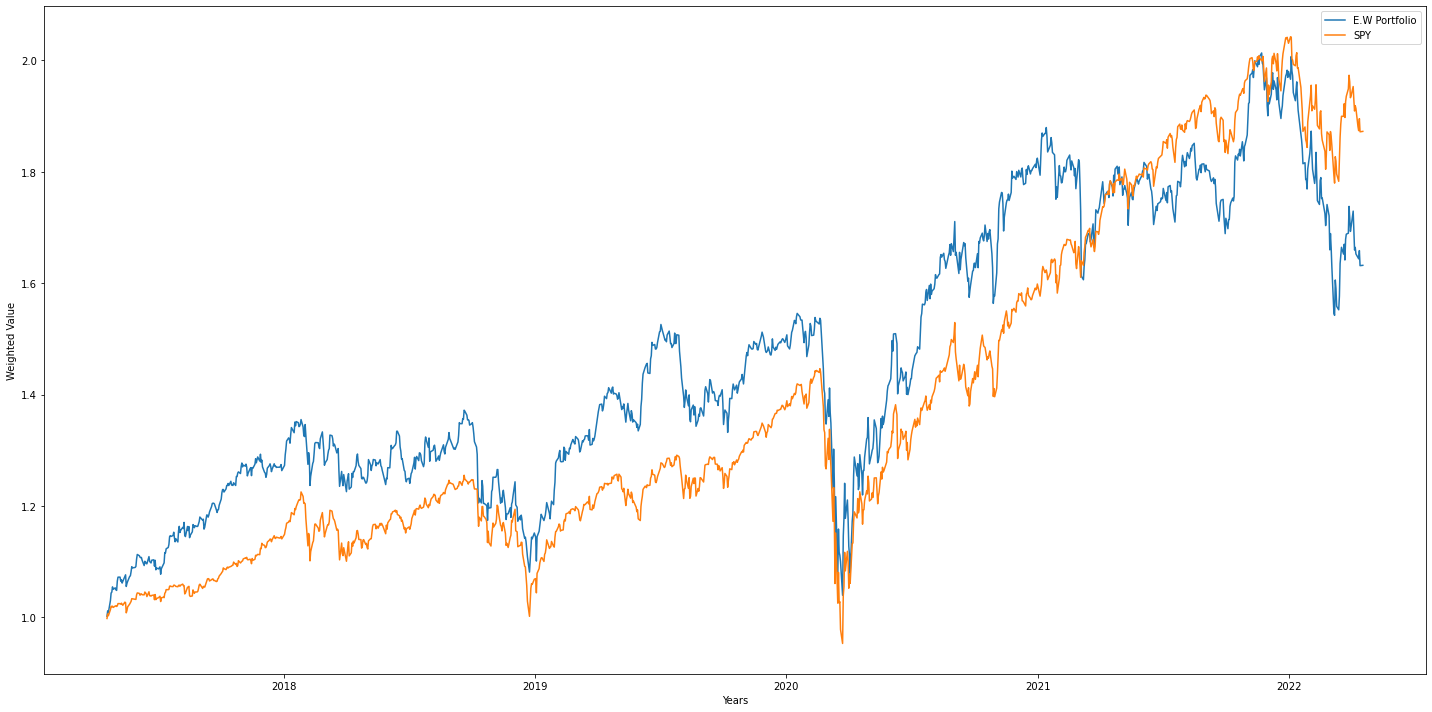

In [29]:
#Plot the comparison data
#def com():
spy_cumulative = cumulative_returns(spy)                                                             #Get cumulative return ffor benchmark
comparison = pd.concat([portfolio_price_action,spy_cumulative],axis = 1 ,join = 'inner').dropna()    #Concat both df
comparison = comparison.rename(columns = {0:'E.W Portfolio'})   
    
comparison = comparison.plot(figsize = (20,10), kind="line", ylabel='Weighted Value', xlabel='Years')
#    return comparison

<AxesSubplot:xlabel='Years', ylabel='Weighted Value'>

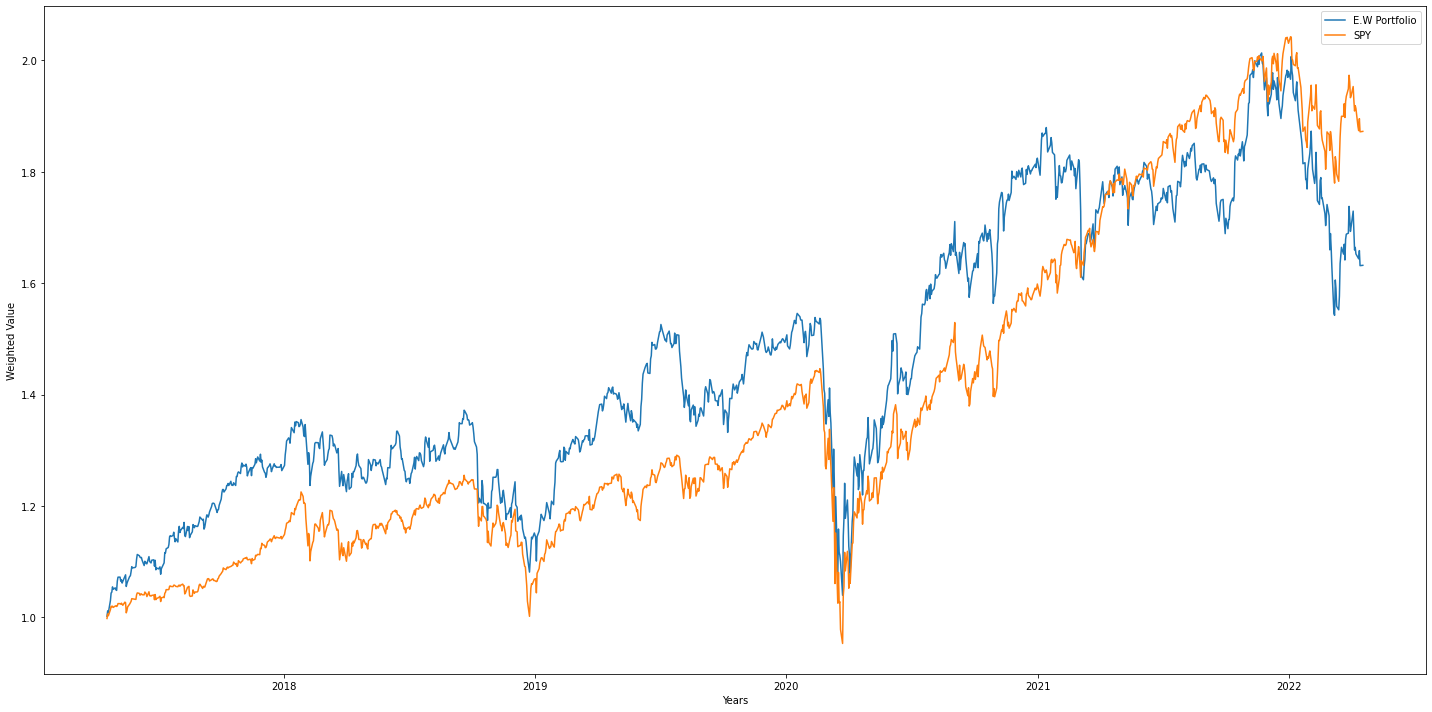

In [25]:
com()

# Calculate volatility based on the MC stats
#volatility = round(summary_stats[2] * np.sqrt(252) )        #Calculate the volatility
#volatility                                                  #Display the values

In [11]:
# # Annualized Sharpe Ratios
# annualized_sharpe_ratio = (portfolio_joint.mean()* 252) / (portfolio_joint.std() * np.sqrt(252))

# # Visualize the sharpe ratios as a bar plot
# annualized_sharpe_ratio.plot(kind = "bar", title = "Sharpe Ration", figsize = (5,5), ylabel="Ratio", xlabel="Tiker Name", color='g')
# plt.savefig('Images/Sharpe Ratio.png', bbox_inches='tight')                   #Save the graph

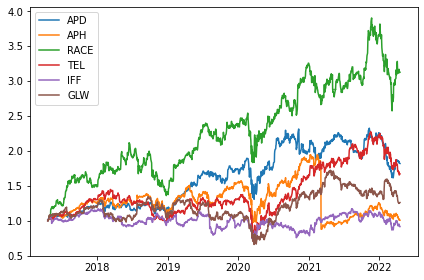

In [34]:

line_chart = portfolio_cumulative.plot.line()
line_chart

def create_bar_chart(data, title, xlabel, ylabel): 
    #bar_chart_plot = plt.figure(figsize=(4,6))
    bar_chart = data.plot.line(title=title)
    plt.ylabel(ylabel, fontsize='7')
    plt.xlabel(xlabel, fontsize='7')
    plt.subplots_adjust(bottom = 0.6)
    plt.tick_params(labelsize=5, labelcolor='b')
    return plt
    

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\envs\\pyvizenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

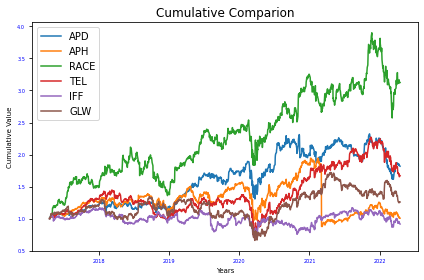

In [35]:
create_bar_chart(portfolio_cumulative, title='Cumulative Comparion', xlabel='Years', ylabel='Cumulative Value')
create_bar_chart(comparison, title='Comparion Chart', xlabel='Years', ylabel='Weighted Value')

Tabs
    [0] Column(height=1200, sizing_mode='fixed', width=1200)
        [0] Markdown(str)
        [1] IPyWidget(interactive)
    [1] Column(height=1200, sizing_mode='fixed', width=1200)
        [0] Markdown(str)
        [1] IPyWidget(interactive)
    [2] Column
        [0] Str(module)
        [1] Str(AxesSubplot)

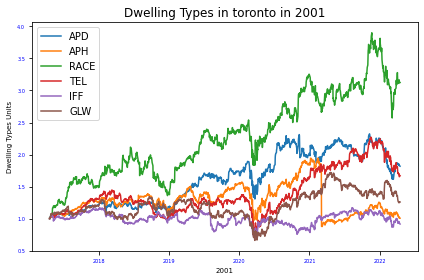

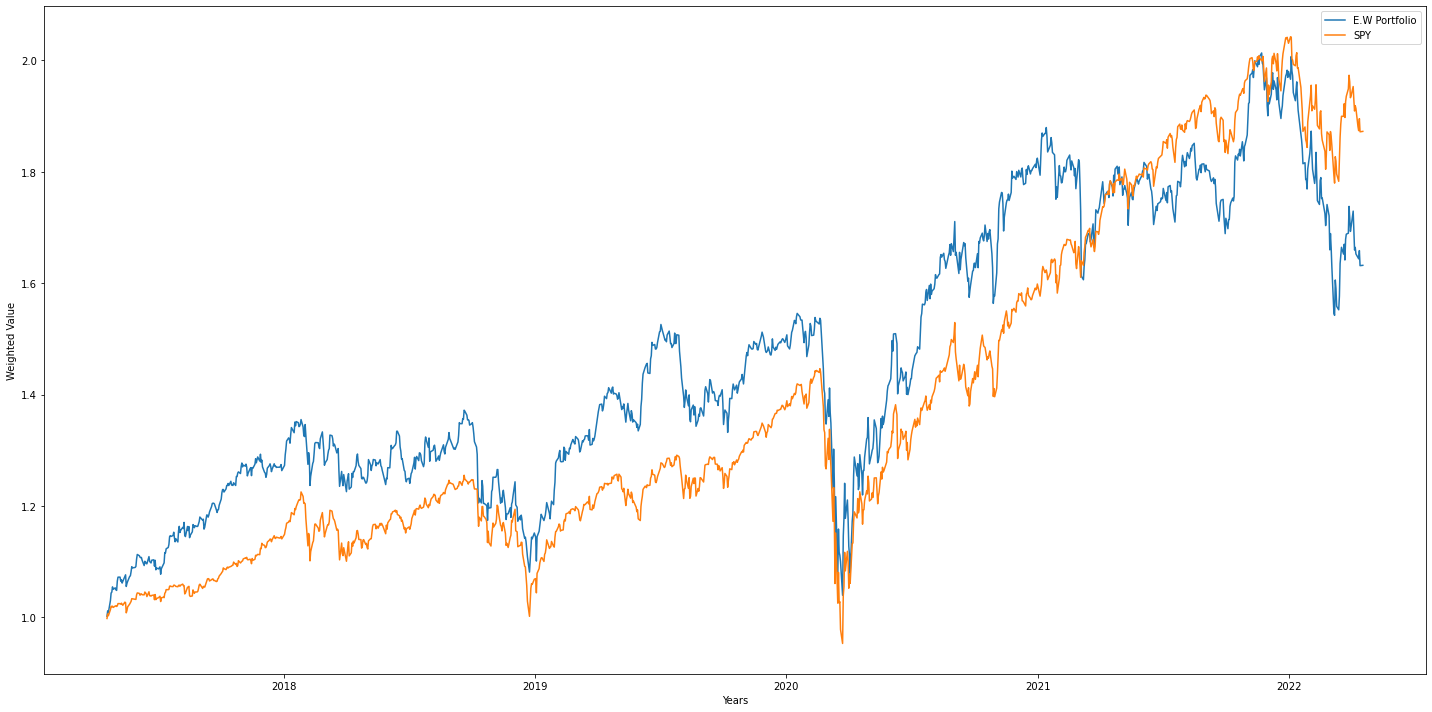

In [26]:
title = pn.pane.Markdown(""" 
        ### Responsible Investor """,  
        width=900)


tabs = pn.Tabs(
    ("Monte Carlo simulation", 
     pn.Column("Choose your trading years", interactive(MC_simulation, Years=([1, 3, 5]), value=None), 
               height=1200, width=1200
              )
    ),
    ("Confidence level", 
     pn.Column("Choose your initial investment amount", 
               interactive(confidence_level, Investment=['$5,000', '$10,000', '$15,000'], value=None),
               height=1200, width=1200
              )
    ),
    ("Plots",
       pn.Column(
           create_bar_chart(portfolio_cumulative, title='Dwelling Types in toronto in 2001', xlabel='2001', ylabel='Dwelling Types Units', color='Red'),
           com()
       )
    )
)

tabs
#panel = pn.Column(pn.Column(title), tabs, width=50, height=500)
#panel